In [42]:
import pandas as pd
from model.comment import Comment
from model.user import User
from datetime import datetime
from tqdm import tqdm
from copy import deepcopy
import networkx as nx
from karateclub import SCD, EdMot
import json
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('../data/comments.csv')

In [44]:
df.head()

,Unnamed: 0,by,id,kids,parent,text,time,type,deleted,dead
0,0,['Jonnax'],[24563821],"[24564014, 24563951, 24565071, 24563883, 24564...",[24563698],['There&#x27;s a quote from the CEO saying tha...,['2020-09-23 08:58:07'],['comment'],{},{}
1,1,['pkphilip'],[24563987],"[24564606, 24564531, 24564249]",[24563698],['It is interesting to note that Brendan Eich&...,['2020-09-23 09:20:14'],['comment'],{},{}
2,2,['rattray'],[24565829],[24565871],[24563698],['This is a pretty unfair article.<p>The autho...,['2020-09-23 13:45:24'],['comment'],{},{}
3,3,['bambax'],[24564488],"[24564530, 24565153, 24564755, 24565320]",[24563698],['&gt; <i>Mobile browsing numbers are bleak: F...,['2020-09-23 10:30:43'],['comment'],{},{}
4,4,['shp0ngle'],[24563843],"[24564784, 24563894, 24563980, 24563875, 24564...",[24563698],['I&#x27;m two fences on Firefox doing &quot;t...,['2020-09-23 09:01:00'],['comment'],{},{}


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77728 entries, 0 to 77727
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  77728 non-null  int64 
 1   by          77728 non-null  object
 2   id          77728 non-null  object
 3   kids        77728 non-null  object
 4   parent      77728 non-null  object
 5   text        77728 non-null  object
 6   time        77728 non-null  object
 7   type        77728 non-null  object
 8   deleted     77728 non-null  object
 9   dead        77728 non-null  object
dtypes: int64(1), object(9)
memory usage: 5.9+ MB


In [46]:
len(df['by'].unique())

25912

In [47]:
len(df['id'].unique())

77651

In [48]:
def row_to_comment(row):

    kids = []
    if row['kids'] != '{}':
        kids = list(map(int, row['kids'][1:-1].split(', ')))[0],

    return Comment(
        by_id=row['by'][2:-2],
        id=int(row['id'][1:-1]),
        parent_id=int(row['parent'][1:-1]),
        kids_ids=kids,
        text=row['text'][2:-2],
        time=datetime.strptime(row['time'][2:-2], '%Y-%m-%d %H:%M:%S'),
        type=row['type'][2:-2],
        by=None,
        parent=None,
        kids=None
    )

In [49]:
def row_to_user(row):

    return User(
        name=row['by'][2:-2],
        comments_ids=[],
        comments=[]
    )

In [50]:
users = {}
comments = {}

for row_id in tqdm(range(len(df))):
    row = df.iloc[row_id]

    try:
        if row['by'][2:-2] != '':

            #add comment
            next_comment = row_to_comment(row)
            if next_comment.id in comments:
                # print(row)
                pass
            else:
                comments[next_comment.id] = next_comment

            #add user and comment to user
            next_user = row_to_user(row)
            if next_user.name not in users:
                users[next_user.name] = next_user
            users[next_user.name].comments_ids.append(next_comment.id)
            users[next_user.name].comments.append(next_comment)

    except Exception as e:
        print(e)
        print(row)

100%|██████████| 77728/77728 [00:14<00:00, 5425.56it/s]


In [51]:
len(users)

25911

In [52]:
len(comments)

75212

In [53]:
def create_empty_comment(id):
    return Comment(
        id=id,
        by_id=None,
        parent_id=None,
        kids_ids=None,
        text=None,
        time=None,
        type=None,
        by=None,
        parent=None,
        kids=None
    )

In [54]:
# fill by, parent, kids fields in comments
# if comment not found in comments create that object
current_comments_list = deepcopy(list(comments.values()))

for comment in tqdm(current_comments_list):

    comments[comment.id].by = users[comment.by_id]

    if comment.parent_id not in comments:
        # comments[comment.parent_id] = create_empty_comment(comment.parent_id)
        comments[comment.parent_id] = Comment(
            id=comment.parent_id,
            by_id=None,
            parent_id=None,
            kids_ids=[comment.id],
            text=None,
            time=None,
            type=None,
            by=None,
            parent=None,
            kids=[comment]
        )
    elif comment.id not in comments[comment.parent_id].kids_ids:
        comments[comment.parent_id].kids_ids.append(comment.id)
        comments[comment.parent_id].kids.append(comment)
    comments[comment.id].parent = comments[comment.parent_id]

    comments[comment.id].kids = []
    for subcomment_id in comment.kids_ids:
        if subcomment_id not in comments:
            # comments[subcomment_id] = create_empty_comment(subcomment_id)
            comments[subcomment_id] = Comment(
                id=subcomment_id,
                by_id=None,
                parent_id=comment.id,
                kids_ids=None,
                text=None,
                time=None,
                type=None,
                by=None,
                parent=comment,
                kids=None
            )
        comments[comment.id].kids.append(comments[subcomment_id])

100%|██████████| 75212/75212 [00:00<00:00, 101174.37it/s]


In [55]:
len(comments)

119338

In [56]:
len(set(map(lambda x: x.id, list(comments.values())))) == len(comments)

True

## Waga - zliczanie wystąpień

In [57]:
roots = list(filter(lambda x: x.parent==None, list(comments.values())))

In [58]:
len(roots)

4683

In [59]:
groups = []

for root in roots:

    group = []
    if root.by_id is not None:
        group.append(root.by_id)
    kids = root.kids

    while len(kids) > 0:
        kid = kids.pop()
        # group.append(kid)
        if kid.by_id is not None and kid.by_id not in group:
            group.append(kid.by_id)
        if kid.kids is not None:
            kids.append(*kid.kids)

    groups.append(group)

In [60]:
len(groups)

4683

In [61]:
min(list(map(len, groups)))

1

In [62]:
max(list(map(len, groups)))

619

In [63]:
G = nx.Graph()

In [64]:
for group in groups:
    group = list(set(group))
    while len(group) > 0:
        user_id = group.pop()
        for other_user_id in group:
            if G.has_edge(user_id, other_user_id):
                G[user_id][other_user_id]['w'] += 1
            else:
                G.add_edge(user_id, other_user_id, w=1)

In [65]:
len(G.nodes)

25877

In [66]:
len(G.edges)

1695665

In [67]:
nx.density(G)

0.005064761315724848

In [68]:
components = list(nx.connected_components(G))
print(len(components))

15


In [69]:
list(map(len, components))

[25844, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2]

In [70]:
G = G.subgraph(components[0])

In [71]:
# G = nx.relabel.convert_node_labels_to_integers(G, label_attribute='user_id')

In [72]:
# # detector = SCD(iterations=6)
# detector = EdMot()
# detector.fit(G)
# members = detector.get_memberships()

In [73]:
# max(list(members.values()))

In [74]:
# with open('members.json', 'w') as outfile:
#     json.dump(members, outfile)

## Degrees distribution

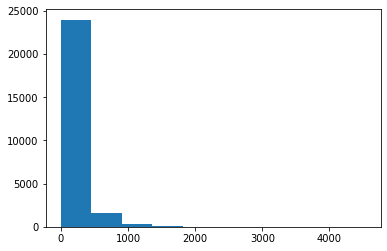

In [75]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)
plt.show()

In [76]:
max(degrees)

4533

In [77]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[0:10]

[('dang', 4533),
 ('Animats', 3544),
 ('znpy', 2790),
 ('supernova87a', 2318),
 ('MattGaiser', 2313),
 ('sidcool', 2150),
 ('jedberg', 2132),
 ('29athrowaway', 2112),
 ('gitgud', 2092),
 ('crazygringo', 2084)]

In [78]:
degrees = list(filter(lambda x: x < 1000, degrees))

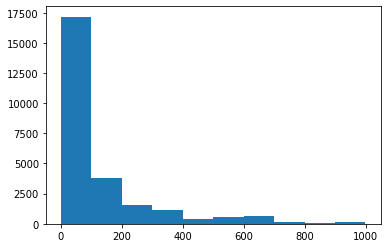

In [79]:
plt.hist(degrees)
plt.show()

## Comments number distribution

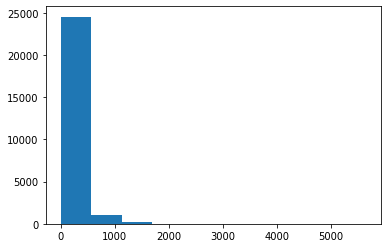

In [81]:
degrees = [G.degree(n, weight='w') for n in G.nodes()]
plt.hist(degrees)
plt.show()

In [82]:
max(degrees)

5639

In [84]:
sorted(G.degree(weight='w'), key=lambda x: x[1], reverse=True)[0:10]

[('dang', 5639),
 ('Animats', 4625),
 ('znpy', 3172),
 ('supernova87a', 2790),
 ('MattGaiser', 2730),
 ('crazygringo', 2428),
 ('jedberg', 2406),
 ('29athrowaway', 2402),
 ('m0zg', 2388),
 ('gitgud', 2302)]

## Graph density

In [85]:
nx.density(G)

0.005077626274256195

## Graph diameter

In [86]:
# nx.diameter(G)

KeyboardInterrupt: 